In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [19]:
class Net(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, input):
        a1 = F.relu(self.conv1(input))
        a1 = F.max_pool2d(a1, (2,2))

        a2 = F.relu(self.conv2(a1))
        a2 = F.max_pool2d(a2, (2,2))
        a2 = torch.flatten(a2,1)

        a3 = F.relu(self.fc1(a2))

        a4 = F.relu(self.fc2(a3))

        output = self.fc3(a4)

        return output
        

In [20]:
#Test Forward
net = Net()
x = torch.rand(4, 3, 32, 32)
output = net(x)
output

tensor([[ 0.0118,  0.0239,  0.1310, -0.0456,  0.0237, -0.0063,  0.0784, -0.0774,
         -0.0808,  0.0082],
        [ 0.0152,  0.0287,  0.1324, -0.0460,  0.0169, -0.0095,  0.0805, -0.0830,
         -0.0783,  0.0040],
        [ 0.0118,  0.0272,  0.1388, -0.0442,  0.0247, -0.0036,  0.0832, -0.0815,
         -0.0804,  0.0096],
        [ 0.0174,  0.0295,  0.1379, -0.0417,  0.0217, -0.0110,  0.0815, -0.0844,
         -0.0764,  0.0057]], grad_fn=<AddmmBackward0>)

In [21]:
#Load Data
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4
validation_split = 0.1  # Percentage of the training dataset to be used as validation

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

train_size = int((1 - validation_split) * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Train dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")
print(f"Test dataset size: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 45000
Validation dataset size: 5000
Test dataset size: 10000


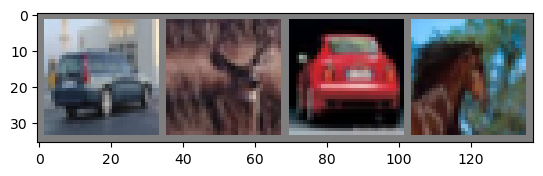

car   deer  car   horse


In [5]:
#Utils functions

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [29]:
net.to(device)
#Defining Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [30]:
#Train
EPOCHS = 3
train_lossess = []
val_losses = []

for epoch in range(EPOCHS):
    running_loss = 0.0
    val_loss = 0.0
    train_size = len(trainset)

    for i, data in enumerate(trainloader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        prediction = net(images)
        loss = criterion(prediction, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            prediction = net(images)
            val_loss += criterion(prediction, labels)
    
    train_lossess.append(running_loss / train_size)
    val_losses.append(val_loss / len(valset))

    print(f"End Epoch {epoch + 1} - Avg Loss: {running_loss / train_size} - Avg Val Loss: {val_loss / len(valset)}")


End Epoch 1 - Avg Loss: 0.23214153298855655 - Avg Val Loss: 0.27446162700653076
End Epoch 2 - Avg Loss: 0.2196214210774077 - Avg Val Loss: 0.2668403387069702
End Epoch 3 - Avg Loss: 0.20929184360444777 - Avg Val Loss: 0.2659774422645569


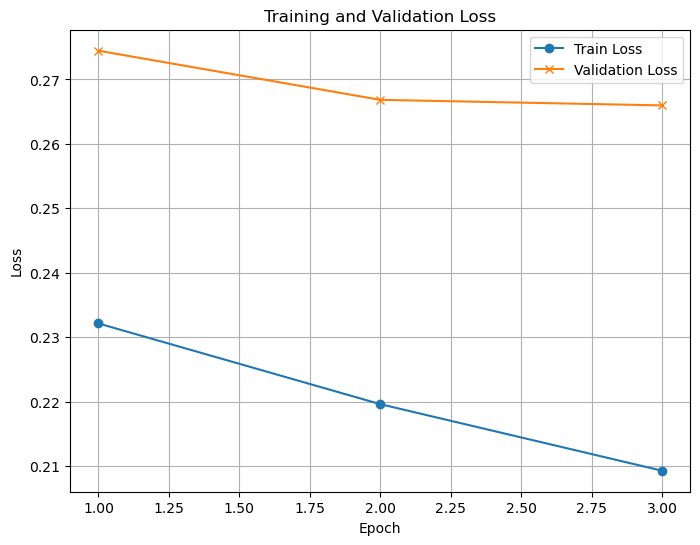

In [31]:
# Si train_lossess y val_losses son tensores, conviértelos a listas
train_lossess = [loss.cpu().item() for loss in train_lossess] if isinstance(train_lossess[0], torch.Tensor) else train_lossess
val_losses = [loss.cpu().item() for loss in val_losses] if isinstance(val_losses[0], torch.Tensor) else val_losses

# Crear la figura
plt.figure(figsize=(8, 6))

# Añadir las curvas con etiquetas
plt.plot(range(1, len(train_lossess) + 1), train_lossess, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='x')

# Etiquetas de los ejes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Título
plt.title('Training and Validation Loss')

# Añadir la leyenda después de etiquetar las curvas
plt.legend()

# Agregar una rejilla opcional
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [32]:
#Save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Testing

In [33]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [34]:
total = 0
corrects = 0

with torch.no_grad():
    for i, data in enumerate(testloader):
        image, labels = data[0], data[1]
        output = net(image)
        _, prediction = torch.max(output, 1)
        total += labels.size(0)
        corrects += (prediction == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * corrects // total} %')

Accuracy of the network on the 10000 test images: 65 %
